dataset upload.


In [1]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


In [2]:
!unzip data.zip


Archive:  data.zip
   creating: data/host/
  inflating: data/host/000002.png    
  inflating: data/host/000003 (3).png  
  inflating: data/host/000003 (4).png  
  inflating: data/host/000009 (4).png  
  inflating: data/host/000010.png    
  inflating: data/host/000016 (3).png  
  inflating: data/host/000016 (4).png  
  inflating: data/host/10 - Copy - Copy.png  
  inflating: data/host/10 - Copy (2) - Copy.png  
  inflating: data/host/10 - Copy (2).png  
  inflating: data/host/10 (2) - Copy.png  
  inflating: data/host/10.png        
  inflating: data/host/11 - Copy - Copy.png  
  inflating: data/host/11 - Copy (2) - Copy.png  
  inflating: data/host/11 - Copy (2).png  
  inflating: data/host/11 - Copy (3).png  
  inflating: data/host/11 - Copy.png  
  inflating: data/host/11 (2) - Copy.png  
  inflating: data/host/11 (2).png    
  inflating: data/host/11.png        
  inflating: data/host/12 - Copy - Copy.png  
  inflating: data/host/12 - Copy (2) - Copy.png  
  inflating: data/host/12

new_approch

In [4]:
# ===============================
# DWT + AlphaNet Training (NON-BLIND, Research Grade)
# Optimizes: NC + PSNR + SSIM (via loss proxies)
# ===============================

!pip install pytorch_wavelets scikit-image --quiet

import os, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import numpy as np
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# AlphaNet (Embedder)
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return 0.002 + self.net(x) * 0.018  # [0.002, 0.02]

# -------------------------------
# DWT Layers
# -------------------------------
dwt  = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utils
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size,size))
    img = torch.tensor(img/255.0, dtype=torch.float32)
    return img.unsqueeze(0).unsqueeze(0).to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)
    LH = Yh[0][:,:,0,:,:]
    HL = Yh[0][:,:,1,:,:]
    HH = Yh[0][:,:,2,:,:]

    wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear', align_corners=False)

    LH_w = LH + alpha * wm_resized
    HL_w = HL + alpha * wm_resized

    Yh_w = torch.stack([LH_w, HL_w, HH], dim=2)
    wm_img = idwt((Yl, [Yh_w]))

    return wm_img, wm_resized

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm   = dwt(wm_img)

    LH_host = Yh_host[0][:,:,0,:,:]
    HL_host = Yh_host[0][:,:,1,:,:]
    LH_wm   = Yh_wm[0][:,:,0,:,:]
    HL_wm   = Yh_wm[0][:,:,1,:,:]

    wm_ext = (LH_wm - LH_host + HL_wm - HL_host) / (2 * alpha + 1e-8)
    return wm_ext

def normalized_correlation_torch(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return (w1*w2).sum() / (torch.sqrt((w1**2).sum()*(w2**2).sum()) + 1e-8)

# -------------------------------
# Dataset
# -------------------------------
HOST_DIR = "data/host"
WM_DIR   = "data/watermark"
epochs = 80

host_files = os.listdir(HOST_DIR)
wm_files   = os.listdir(WM_DIR)

# -------------------------------
# Model & Optimizer
# -------------------------------
embedder = AlphaNet().to(device)
optimizer = optim.Adam(embedder.parameters(), lr=1e-4)

# -------------------------------
# Loss Weights (CRITICAL)
# -------------------------------
lambda_wm   = 1.0    # watermark reconstruction
lambda_img  = 0.1    # image imperceptibility
lambda_alpha= 0.01   # alpha regularization

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(epochs):
    total_loss, psnr_avg, ssim_avg, nc_avg = 0, 0, 0, 0
    count = 0
    random.shuffle(host_files)

    for h_file in host_files:
        host = load_gray(os.path.join(HOST_DIR, h_file))
        wm   = load_gray(os.path.join(WM_DIR, random.choice(wm_files)), size=host.shape[-1])

        # ---- Predict Alpha ----
        alpha = embedder(host)  # shape [1,1]

        # ---- Embed ----
        wm_img, wm_resized = embed_frequency(host, wm, alpha)

        # ---- Extract (NON-BLIND) ----
        wm_ext = extract_frequency(wm_img, host, alpha)

        # ---- LOSSES ----

        # 1. Watermark reconstruction loss
        loss_wm = F.mse_loss(wm_ext, wm_resized)

        # 2. Imperceptibility loss (image distortion)
        loss_img = F.mse_loss(wm_img, host)

        # 3. Alpha regularization (prevent too large alpha)
        loss_alpha = torch.mean(alpha**2)

        # Total loss
        loss = lambda_wm*loss_wm + lambda_img*loss_img + lambda_alpha*loss_alpha

        # ---- Backprop ----
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ---- Metrics (for logging only) ----
        host_np = host.squeeze().detach().cpu().numpy()
        wm_img_np = wm_img.squeeze().detach().cpu().numpy()

        psnr_avg += psnr(host_np, wm_img_np, data_range=1.0)
        ssim_avg += ssim(host_np, wm_img_np, data_range=1.0)
        nc_avg   += normalized_correlation_torch(wm_resized, wm_ext).item()

        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"Loss: {total_loss/count:.6f} | "
          f"PSNR: {psnr_avg/count:.2f} | "
          f"SSIM: {ssim_avg/count:.4f} | "
          f"NC: {nc_avg/count:.4f}")

# -------------------------------
# Save Model
# -------------------------------
torch.save(embedder.state_dict(), "alpha_net.pth")
print("AlphaNet trained & saved as alpha_net.pth")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.2 MB/s eta 0:00:00
Epoch 001/80 | Loss: 0.000006 | PSNR: 42.99 | SSIM: 0.9754 | NC: 1.0000
Epoch 002/80 | Loss: 0.000006 | PSNR: 43.33 | SSIM: 0.9771 | NC: 1.0000
Epoch 003/80 | Loss: 0.000005 | PSNR: 43.62 | SSIM: 0.9787 | NC: 1.0000
Epoch 004/80 | Loss: 0.000005 | PSNR: 44.03 | SSIM: 0.9804 | NC: 1.0000
Epoch 005/80 | Loss: 0.000004 | PSNR: 44.62 | SSIM: 0.9829 | NC: 1.0000
Epoch 006/80 | Loss: 0.000004 | PSNR: 45.33 | SSIM: 0.9854 | NC: 1.0000
Epoch 007/80 | Loss: 0.000003 | PSNR: 46.30 | SSIM: 0.9881 | NC: 1.0000
Epoch 008/80 | Loss: 0.000002 | PSNR: 47.59 | SSIM: 0.9910 | NC: 1.0000
Epoch 009/80 | Loss: 0.000002 | PSNR: 49.11 | SSIM: 0.9933 | NC: 1.0000
Epoch 010/80 | Loss: 0.000001 | PSNR: 50.84 | SSIM: 0.9953 | NC: 1.0000
Epoch 011/80 | Loss: 0.000001 | PSNR: 52.73 | SSIM: 0.9969 | NC: 1.0000
Epoch 012/80 | Loss: 0.000000 | PSNR: 54.16 | SSIM: 0.9978 | NC: 1.0000
Epoch 013/80 | Loss: 0.000000 | PSNR: 55.07 | SSIM: 0.9982

AlphaNet loaded successfully.
Predicted Alpha: 0.002000
PSNR: 57.62 dB
SSIM: 0.9996
NC:   1.0000


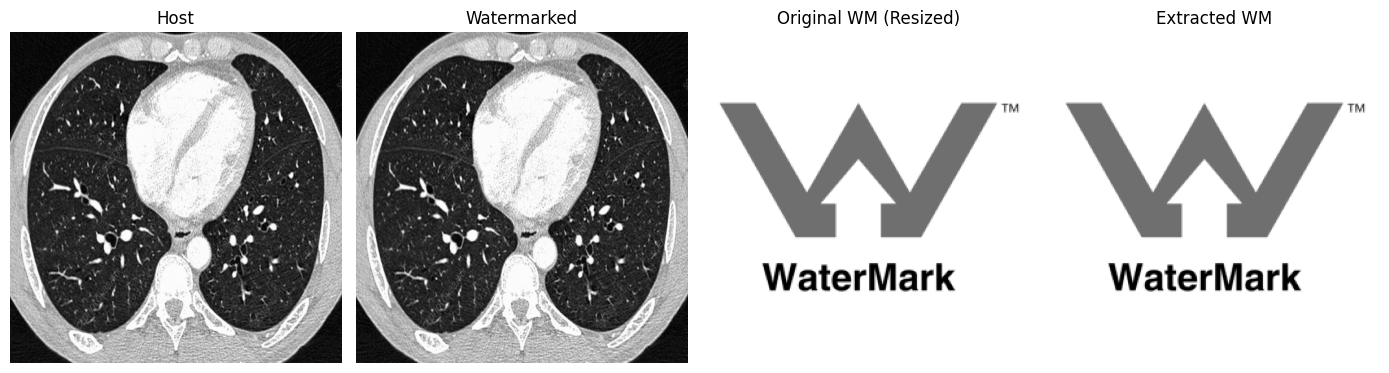

In [5]:
# ===============================
# AlphaNet DWT Watermarking - TEST / INFERENCE
# ===============================

!pip install pytorch_wavelets scikit-image --quiet

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# AlphaNet
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return 0.002 + self.net(x) * 0.018

# -------------------------------
# Load Model
# -------------------------------
model = AlphaNet().to(device)
model.load_state_dict(torch.load("alpha_net.pth", map_location=device))
model.eval()
print("AlphaNet loaded successfully.")

# -------------------------------
# DWT
# -------------------------------
dwt  = DWTForward(J=1, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utils
# -------------------------------
def load_gray_np(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size,size))
    return img.astype(np.float32)/255.0

def to_tensor(img_np):
    return torch.tensor(img_np).unsqueeze(0).unsqueeze(0).float().to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)
    LH = Yh[0][:,:,0,:,:]
    HL = Yh[0][:,:,1,:,:]
    HH = Yh[0][:,:,2,:,:]

    wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear', align_corners=False)

    LH_w = LH + alpha * wm_resized
    HL_w = HL + alpha * wm_resized

    Yh_w = torch.stack([LH_w, HL_w, HH], dim=2)
    wm_img = idwt((Yl, [Yh_w]))
    return wm_img, wm_resized

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm   = dwt(wm_img)

    LH_host = Yh_host[0][:,:,0,:,:]
    HL_host = Yh_host[0][:,:,1,:,:]
    LH_wm   = Yh_wm[0][:,:,0,:,:]
    HL_wm   = Yh_wm[0][:,:,1,:,:]

    wm_ext = (LH_wm - LH_host + HL_wm - HL_host) / (2*alpha + 1e-8)
    return wm_ext

def normalized_correlation_np(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return np.sum(w1*w2) / (np.sqrt(np.sum(w1**2)*np.sum(w2**2)) + 1e-8)

# -------------------------------
# TEST IMAGE PATHS (CHANGE)
# -------------------------------
host_path = "host.png"
wm_path   = "watermark.png"

# -------------------------------
# Load Images
# -------------------------------
host_np = load_gray_np(host_path)
wm_np   = load_gray_np(wm_path)

host_t = to_tensor(host_np)
wm_t   = to_tensor(wm_np)

# -------------------------------
# Predict Alpha
# -------------------------------
with torch.no_grad():
    alpha = model(host_t)[0,0].item()

print(f"Predicted Alpha: {alpha:.6f}")

# -------------------------------
# Embed + Extract
# -------------------------------
wm_img_t, wm_resized_t = embed_frequency(host_t, wm_t, alpha)
wm_ext_t = extract_frequency(wm_img_t, host_t, alpha)

# -------------------------------
# Convert to NumPy
# -------------------------------
wm_img_np = wm_img_t.squeeze().cpu().numpy()
wm_ext_np = wm_ext_t.squeeze().cpu().numpy()
wm_resized_np = wm_resized_t.squeeze().cpu().numpy()

# -------------------------------
# Metrics
# -------------------------------
psnr_val = psnr(host_np, wm_img_np, data_range=1.0)
ssim_val = ssim(host_np, wm_img_np, data_range=1.0)
nc_val   = normalized_correlation_np(wm_resized_np, wm_ext_np)

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")
print(f"NC:   {nc_val:.4f}")

# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(14,5))

plt.subplot(1,4,1)
plt.title("Host")
plt.imshow(host_np, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title("Watermarked")
plt.imshow(wm_img_np, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title("Original WM (Resized)")
plt.imshow(wm_resized_np, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title("Extracted WM")
plt.imshow(wm_ext_np, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
# ===============================
# DWT + AlphaNet ROBUST TRAINING (FIXED SHAPE + HIGH NC)
# ===============================

!pip install pytorch_wavelets kornia scikit-image --quiet

import os, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import kornia
from pytorch_wavelets import DWTForward, DWTInverse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# AlphaNet
# -------------------------------
class AlphaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return 0.01 + self.net(x) * 0.05  # Slightly higher alpha for robustness

# -------------------------------
# DWT
# -------------------------------
dwt  = DWTForward(J=2, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Utils
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size,size))
    return torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)
    wm_resized_list = []
    for j in range(len(Yh)):
        LH, HL, HH = Yh[j][:,:,0,:,:], Yh[j][:,:,1,:,:], Yh[j][:,:,2,:,:]
        # Resize watermark to match this DWT level
        wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear', align_corners=False)
        wm_resized_list.append(wm_resized)
        LH = LH + alpha * wm_resized
        HL = HL + alpha * wm_resized
        Yh[j] = torch.stack([LH, HL, HH], dim=2)
    wm_img = idwt((Yl, Yh))
    return wm_img, wm_resized_list  # return list of resized watermarks per level

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm   = dwt(wm_img)

    wm_ext_list = []
    target_size = Yh_host[0].shape[-2:]  # Resize all HF bands to first DWT level size
    for j in range(len(Yh_host)):
        LH_h, HL_h = Yh_host[j][:,:,0,:,:], Yh_host[j][:,:,1,:,:]
        LH_w, HL_w = Yh_wm[j][:,:,0,:,:], Yh_wm[j][:,:,1,:,:]

        # Resize to first level size
        LH_h = F.interpolate(LH_h, size=target_size, mode='bilinear', align_corners=False)
        HL_h = F.interpolate(HL_h, size=target_size, mode='bilinear', align_corners=False)
        LH_w = F.interpolate(LH_w, size=target_size, mode='bilinear', align_corners=False)
        HL_w = F.interpolate(HL_w, size=target_size, mode='bilinear', align_corners=False)

        wm_ext_list.append((LH_w - LH_h + HL_w - HL_h) / (2*alpha + 1e-8))

    wm_ext = sum(wm_ext_list) / len(wm_ext_list)  # average over all levels
    return wm_ext

def normalized_correlation_torch(w1, w2):
    w1 = w1.flatten()
    w2 = w2.flatten()
    return (w1*w2).sum() / (torch.sqrt((w1**2).sum()*(w2**2).sum()) + 1e-8)

# -------------------------------
# Differentiable Attacks
# -------------------------------
def apply_attacks(img):
    out = img
    if random.random() < 0.5:
        out = torch.clamp(out + torch.randn_like(out)*random.uniform(0.002,0.01),0,1)
    if random.random() < 0.5:
        out = kornia.filters.gaussian_blur2d(out, (3,3), (1.0,1.0))
    if random.random() < 0.5:
        H,W = out.shape[-2:]
        scale = random.uniform(0.7,0.9)
        out_small = F.interpolate(out, scale_factor=scale, mode='bilinear')
        out = F.interpolate(out_small, size=(H,W), mode='bilinear')
    if random.random() < 0.5:
        out = kornia.filters.gaussian_blur2d(out, (5,5), (1.5,1.5))
        q = random.uniform(0.002,0.01)
        out = torch.round(out / q) * q
        out = torch.clamp(out,0,1)
    return out

# -------------------------------
# Dataset
# -------------------------------
HOST_DIR = "data/host"
WM_DIR   = "data/watermark"
epochs = 80

host_files = os.listdir(HOST_DIR)
wm_files   = os.listdir(WM_DIR)

# -------------------------------
# Model & Optimizer
# -------------------------------
embedder = AlphaNet().to(device)
optimizer = optim.Adam(embedder.parameters(), lr=1e-4)

# -------------------------------
# Loss Weights
# -------------------------------
lambda_wm_clean  = 0.5
lambda_wm_attack = 1.5
lambda_img       = 0.1
lambda_alpha     = 0.01

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(epochs):
    total_loss, psnr_avg, ssim_avg, nc_clean_avg, nc_attack_avg = 0,0,0,0,0
    count = 0
    random.shuffle(host_files)

    for h_file in host_files:
        host = load_gray(os.path.join(HOST_DIR, h_file))
        wm   = load_gray(os.path.join(WM_DIR, random.choice(wm_files)), size=host.shape[-1])

        # Predict Alpha
        alpha = embedder(host)

        # Embed watermark
        wm_img, wm_resized_list = embed_frequency(host, wm, alpha)

        # Extract clean watermark
        wm_ext_clean = extract_frequency(wm_img, host, alpha)

        # Extract attacked watermark
        wm_img_attacked = apply_attacks(wm_img)
        wm_ext_attack = extract_frequency(wm_img_attacked, host, alpha)

        # Resize & average all level watermarks to match extraction size
        target_size = wm_ext_clean.shape[-2:]
        wm_target = torch.stack([F.interpolate(w, size=target_size, mode='bilinear', align_corners=False)
                                 for w in wm_resized_list], dim=0).mean(dim=0)

        # Losses
        loss_wm_clean  = F.mse_loss(wm_ext_clean, wm_target)
        loss_wm_attack = F.mse_loss(wm_ext_attack, wm_target)
        loss_img       = F.mse_loss(wm_img, host)
        loss_alpha     = torch.mean(alpha**2)

        loss = (lambda_wm_clean*loss_wm_clean +
                lambda_wm_attack*loss_wm_attack +
                lambda_img*loss_img +
                lambda_alpha*loss_alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        host_np = host.squeeze().cpu().numpy()
        wm_img_np = wm_img.squeeze().detach().cpu().numpy()
        psnr_avg += psnr(host_np, wm_img_np, data_range=1.0)
        ssim_avg += ssim(host_np, wm_img_np, data_range=1.0)
        nc_clean_avg  += normalized_correlation_torch(wm_target, wm_ext_clean).item()
        nc_attack_avg += normalized_correlation_torch(wm_target, wm_ext_attack).item()
        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"Loss: {total_loss/count:.6f} | "
          f"PSNR: {psnr_avg/count:.2f} | "
          f"SSIM: {ssim_avg/count:.4f} | "
          f"NC Clean: {nc_clean_avg/count:.4f} | "
          f"NC Attack: {nc_attack_avg/count:.4f}")

# -------------------------------
# Save Model
# -------------------------------
torch.save(embedder.state_dict(), "alpha_net_robust.pth")
print("Robust AlphaNet trained & saved as alpha_net_robust.pth")


Epoch 001/80 | Loss: 1.548622 | PSNR: 31.27 | SSIM: 0.7689 | NC Clean: 1.0000 | NC Attack: 0.2469
Epoch 002/80 | Loss: 1.274905 | PSNR: 30.50 | SSIM: 0.7415 | NC Clean: 1.0000 | NC Attack: 0.3522
Epoch 003/80 | Loss: 1.502370 | PSNR: 29.79 | SSIM: 0.7149 | NC Clean: 1.0000 | NC Attack: 0.2288
Epoch 004/80 | Loss: 1.297527 | PSNR: 29.11 | SSIM: 0.6896 | NC Clean: 1.0000 | NC Attack: 0.2977
Epoch 005/80 | Loss: 1.176630 | PSNR: 28.78 | SSIM: 0.6800 | NC Clean: 1.0000 | NC Attack: 0.3633
Epoch 006/80 | Loss: 1.155499 | PSNR: 28.46 | SSIM: 0.6655 | NC Clean: 1.0000 | NC Attack: 0.4054
Epoch 007/80 | Loss: 1.263854 | PSNR: 28.15 | SSIM: 0.6519 | NC Clean: 1.0000 | NC Attack: 0.3465
Epoch 008/80 | Loss: 1.167263 | PSNR: 28.03 | SSIM: 0.6486 | NC Clean: 1.0000 | NC Attack: 0.3589
Epoch 009/80 | Loss: 1.219179 | PSNR: 27.84 | SSIM: 0.6405 | NC Clean: 1.0000 | NC Attack: 0.3385
Epoch 010/80 | Loss: 1.182796 | PSNR: 27.74 | SSIM: 0.6358 | NC Clean: 1.0000 | NC Attack: 0.3691
Epoch 011/80 | Loss:

AlphaNet loaded successfully!
Watermark embedded, attacked, and extracted successfully!


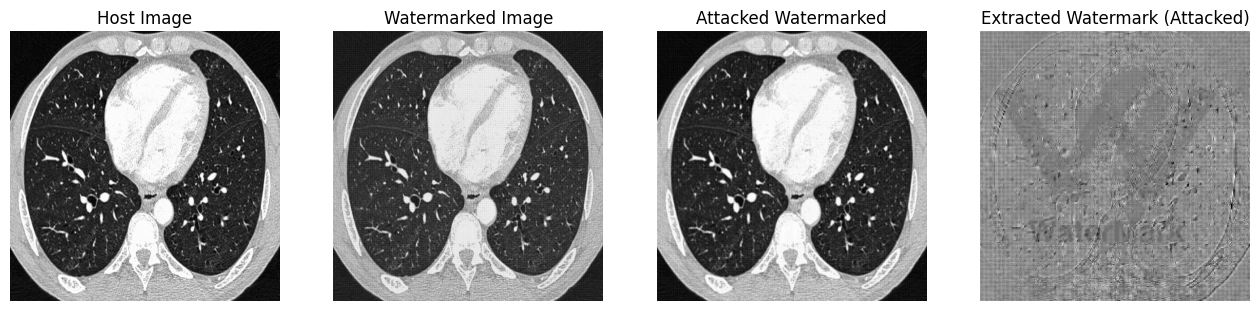

In [19]:
# ================================
# Load Trained AlphaNet & Test + Display Attacked
# ================================

import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from pytorch_wavelets import DWTForward, DWTInverse
import random
import kornia

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Define AlphaNet (same as training)
# -------------------------------
class AlphaNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,2,1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,64,3,2,1),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(64,1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return 0.01 + self.net(x) * 0.05

# -------------------------------
# Load the model
# -------------------------------
embedder = AlphaNet().to(device)
embedder.load_state_dict(torch.load("alpha_net_robust.pth", map_location=device))
embedder.eval()
print("AlphaNet loaded successfully!")

# -------------------------------
# DWT setup
# -------------------------------
dwt  = DWTForward(J=2, wave='haar').to(device)
idwt = DWTInverse(wave='haar').to(device)

# -------------------------------
# Helper functions
# -------------------------------
def load_gray(path, size=512):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size,size))
    return torch.tensor(img/255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

def embed_frequency(host, wm, alpha):
    Yl, Yh = dwt(host)
    for j in range(len(Yh)):
        LH, HL, HH = Yh[j][:,:,0,:,:], Yh[j][:,:,1,:,:], Yh[j][:,:,2,:,:]
        wm_resized = F.interpolate(wm, size=LH.shape[-2:], mode='bilinear', align_corners=False)
        LH = LH + alpha * wm_resized
        HL = HL + alpha * wm_resized
        Yh[j] = torch.stack([LH, HL, HH], dim=2)
    wm_img = idwt((Yl, Yh))
    return wm_img

def extract_frequency(wm_img, host, alpha):
    _, Yh_host = dwt(host)
    _, Yh_wm   = dwt(wm_img)

    wm_ext = 0
    target_size = Yh_host[0].shape[-2:]
    for j in range(len(Yh_host)):
        LH_h, HL_h = Yh_host[j][:,:,0,:,:], Yh_host[j][:,:,1,:,:]
        LH_w, HL_w = Yh_wm[j][:,:,0,:,:], Yh_wm[j][:,:,1,:,:]

        LH_h = F.interpolate(LH_h, size=target_size, mode='bilinear', align_corners=False)
        HL_h = F.interpolate(HL_h, size=target_size, mode='bilinear', align_corners=False)
        LH_w = F.interpolate(LH_w, size=target_size, mode='bilinear', align_corners=False)
        HL_w = F.interpolate(HL_w, size=target_size, mode='bilinear', align_corners=False)

        wm_ext += (LH_w - LH_h + HL_w - HL_h)

    wm_ext = wm_ext / (2*alpha + 1e-8) / len(Yh_host)
    return wm_ext

# -------------------------------
# Differentiable Attacks
# -------------------------------
def apply_attacks(img):
    out = img
    if random.random() < 0.5:
        out = torch.clamp(out + torch.randn_like(out)*random.uniform(0.002,0.01),0,1)
    if random.random() < 0.5:
        out = kornia.filters.gaussian_blur2d(out, (3,3), (1.0,1.0))
    if random.random() < 0.5:
        H,W = out.shape[-2:]
        scale = random.uniform(0.7,0.9)
        out_small = F.interpolate(out, scale_factor=scale, mode='bilinear')
        out = F.interpolate(out_small, size=(H,W), mode='bilinear')
    if random.random() < 0.5:
        out = kornia.filters.gaussian_blur2d(out, (5,5), (1.5,1.5))
        q = random.uniform(0.002,0.01)
        out = torch.round(out / q) * q
        out = torch.clamp(out,0,1)
    return out

# -------------------------------
# Load images
# -------------------------------
host_path = "host.png"
wm_path   = "watermark.png"

host = load_gray(host_path)
wm   = load_gray(wm_path, size=host.shape[-1])

# Predict alpha
alpha = embedder(host)

# Embed watermark
wm_img = embed_frequency(host, wm, alpha)

# Extract watermark
wm_extracted = extract_frequency(wm_img, host, alpha)

# Apply attack
wm_img_attacked = apply_attacks(wm_img)
wm_extracted_attacked = extract_frequency(wm_img_attacked, host, alpha)

print("Watermark embedded, attacked, and extracted successfully!")

# -------------------------------
# Show images
# -------------------------------
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("Host Image")
plt.imshow(host.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title("Watermarked Image")
plt.imshow(wm_img.squeeze().detach().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title("Attacked Watermarked")
plt.imshow(wm_img_attacked.squeeze().detach().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title("Extracted Watermark (Attacked)")
plt.imshow(wm_extracted_attacked.squeeze().detach().cpu(), cmap='gray')
plt.axis('off')

plt.show()
